In [ ]:
import numpy as np
from numpy.linalg import inv, det, matrix_rank
from PIL import Image
import os
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


In [188]:
# Limpa o console 
os.system('cls' if os.name == 'nt' else 'clear')
part1 = 'subject0'
part2 = 'subject'
part3 = ['.centerlight', '.glasses', '.happy', '.leftlight', '.noglasses', '.normal', '.rightlight', '.sad', '.sleepy', '.surprised', '.wink']

Nind = 15   # Quantidade de individuos
Nexp = len(part3)  # Quantidade de expressoes

X = []  # Lista para acumular imagens vetorizadas
Y = []  # Lista para acumular o rotulo do individuo


In [189]:
for i in range(1, Nind + 1):  # Indice para os individuos
    individuo = i

    for j in range(Nexp):   # Indice para expressoes
        if i < 10:
            nome = f"{part1}{i}{part3[j]}"    # Monta o nome do arquivo de imagem
        else:
            nome = f"{part2}{i}{part3[j]}"

        Img = Image.open(f"../Faces/{nome}").convert('L')  # le imagem e converte para escala de cinza
            
        # Redimensiona imagem
        Ar = Img.resize((20, 20))

        An = np.array(Ar) # An = Ar.copy() # An=imnoise(Ar,'gaussian',0,0.005);  # adiciona ruido (requer implementação de ruído)

        A = An.astype(np.float64) / 255.0  # converte para double precision (normaliza para 0-1)
 
        a = A.flatten()  # Etapa de vetorizacao: Empilhamento das colunas

        ROT = i   # Rotulo = indice do individuo

        X.append(a) # Coloca cada imagem vetorizada como linha da matriz X (será transposta depois)
        Y.append(ROT) # Coloca o rotulo de cada vetor

X = np.array(X).T  # Transpõe para ter cada imagem vetorizada como coluna (como no MATLAB)
Y = np.array(Y)

Y = Y.reshape(1, -1)  # Transforma Y em vetor linha (1xN)

Z = np.vstack((X, Y))  # Formato 01 vetor de atributos por coluna: DIM(Z) = (p+1)xN
Z = Z.T     # Formato 01 vetor de atributos por linha: DIM(Z) = Nx(p+1)

#  Salva os dados em um arquivo .dat
np.savetxt('recfaces.dat', Z, fmt='%.6f') # fmt='%.6f' para manter a precisão float

print("Imagens carregadas e vetorizadas. Dimensão de X:", X.shape)
print("Dimensão de Y:", Y.shape)


Imagens carregadas e vetorizadas. Dimensão de X: (400, 165)
Dimensão de Y: (1, 165)


# Definição das funções dos classificadores

## Função geral para calcular os centróides e matrizes de covariância dos classificadores quadráticos

In [190]:
def calcular_parametros(X_train, y_train, classes):
    p = X_train.shape[1]
    total_samples_train = len(X_train)
    
    # Dicionários para armazenar os parâmetros de cada classe
    means = {}
    raw_covs = {}
    priors = {}
    
    # Calcula os parâmetros para cada classe individualmente
    for c in classes:
        X_train_c = X_train[y_train == c]
        Ni = X_train_c.shape[0]
        
        means[c] = np.mean(X_train_c, axis=0)
        # Usa rowvar=False pois as amostras estão nas linhas e features nas colunas
        # Usa bias=True para dividir por N, conforme fórmulas do projeto
        raw_covs[c] = np.cov(X_train_c, rowvar=False, bias=True) if Ni > 1 else np.zeros((p, p))
        priors[c] = Ni / total_samples_train if total_samples_train > 0 else 0

    # Calcula a matriz de covariância agregada (pooled), necessária para Variantes 2 e 3
    pooled_cov = np.zeros((p, p))
    for c in classes:
        pooled_cov += priors[c] * raw_covs[c]
        
    return means, raw_covs, priors, pooled_cov

## Classificador Quadrático

In [ ]:
def quadratico(D, Nr, Ptrain):
    X_data, y_labels = D[:, :-1], D[:, -1]
    classes = np.unique(y_labels)
    TX_OK = np.zeros(Nr)
    sing_matrices_total = 0

    X_last_run, m_last_run, S_last_run, posto_last_run = None, None, None, None

    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        means, raw_covs, priors, _ = calcular_parametros(X_train, y_train, classes)
        
        inv_covs, log_dets = {}, {}
        sing_matrices_run = 0

        for c in classes:
            try:
                inv_covs[c] = inv(raw_covs[c])
                sign, log_det = np.linalg.slogdet(raw_covs[c])
                log_dets[c] = log_det if sign > 0 else -np.inf
            except np.linalg.LinAlgError:
                sing_matrices_run += 1
                inv_covs[c], log_dets[c] = None, -np.inf
        
        sing_matrices_total += sing_matrices_run
        
        # Verifica se TODAS as matrizes da rodada foram singulares
        if sing_matrices_run == len(classes):
            TX_OK[r] = 0.0 # Se sim, a acurácia real para esta rodada é 0
            # Captura os dados da última rodada mesmo em caso de falha total
            if r == Nr - 1:
                X_last_run = {c: X_train[y_train == c] for c in classes}
                m_last_run = means
                S_last_run = raw_covs
                posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in raw_covs.items()}
            continue # Pula para a próxima rodada

        if r == Nr - 1:
            X_last_run = {c: X_train[y_train == c] for c in classes}
            m_last_run = means
            S_last_run = raw_covs
            posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in raw_covs.items()}

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            scores = {}
            for c in classes:
                if inv_covs[c] is None:
                    scores[c] = np.inf
                    continue
                
                diff = x_test_sample - means[c]
                mahalanobis = diff.T @ inv_covs[c] @ diff
                scores[c] = 0.5 * (mahalanobis + log_dets[c]) - np.log(priors[c] + 1e-9)
            
            predicted_label = min(scores, key=scores.get)
            if predicted_label == y_test[i]:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    stats_df = pd.Series(TX_OK).describe()
    STATS = {'Média': stats_df['mean'], 'Mínimo': stats_df['min'], 'Máximo': stats_df['max'], 'Mediana': stats_df['50%'], 'Desvio Padrão': stats_df['std']}
    
    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices_total

## Variante 1 do Classificador Quadrático

In [192]:
def variante1(D, Nr, Ptrain, lambda_reg=0.01):
    X_data, y_labels = D[:, :-1], D[:, -1]
    classes, p = np.unique(y_labels), X_data.shape[1]
    TX_OK = np.zeros(Nr)
    
    X_last_run, m_last_run, S_last_run, posto_last_run = None, None, None, None

    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        means, raw_covs, priors, _ = calcular_parametros(X_train, y_train, classes)
        
        inv_covs_reg, log_dets_reg, covs_reg = {}, {}, {}

        for c in classes:
            cov_reg = raw_covs[c] + lambda_reg * np.eye(p)
            covs_reg[c] = cov_reg # Armazena para o retorno
            inv_covs_reg[c] = inv(cov_reg)
            sign, log_det = np.linalg.slogdet(cov_reg)
            log_dets_reg[c] = log_det

        if r == Nr - 1:
            X_last_run = {c: X_train[y_train == c] for c in classes}
            m_last_run = means
            S_last_run = covs_reg
            posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in covs_reg.items()}

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            scores = {c: 0.5 * ((x_test_sample - means[c]).T @ inv_covs_reg[c] @ (x_test_sample - means[c]) + log_dets_reg[c]) - np.log(priors[c] + 1e-9) for c in classes}
            predicted_label = min(scores, key=scores.get)
            if predicted_label == y_test[i]:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    stats_df = pd.Series(TX_OK).describe()
    STATS = {'Média': stats_df['mean'], 'Mínimo': stats_df['min'], 'Máximo': stats_df['max'], 'Mediana': stats_df['50%'], 'Desvio Padrão': stats_df['std']}
    
    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, 0

## Variante 2 do Classificador Quadrático

In [193]:
def variante2(D, Nr, Ptrain):
    X_data, y_labels = D[:, :-1], D[:, -1]
    classes = np.unique(y_labels)
    TX_OK = np.zeros(Nr)
    sing_matrices_total = 0

    X_last_run, m_last_run, S_last_run, posto_last_run = None, None, None, None

    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        means, _, priors, pooled_cov = calcular_parametros(X_train, y_train, classes)
        
        if r == Nr - 1:
            X_last_run = {c: X_train[y_train == c] for c in classes}
            m_last_run = means
            S_last_run = {'pooled': pooled_cov} # A matriz é a mesma para todas as classes
            posto_last_run = {'pooled': np.linalg.matrix_rank(pooled_cov)}

        try:
            inv_pooled_cov = inv(pooled_cov)
        except np.linalg.LinAlgError:
            sing_matrices_total += 1
            TX_OK[r] = 0
            continue

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            # O termo do determinante é constante e pode ser omitido na minimização
            scores = {c: 0.5 * ((x_test_sample - means[c]).T @ inv_pooled_cov @ (x_test_sample - means[c])) - np.log(priors[c] + 1e-9) for c in classes}
            predicted_label = min(scores, key=scores.get)
            if predicted_label == y_test[i]:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    stats_df = pd.Series(TX_OK).describe()
    STATS = {'Média': stats_df['mean'], 'Mínimo': stats_df['min'], 'Máximo': stats_df['max'], 'Mediana': stats_df['50%'], 'Desvio Padrão': stats_df['std']}
    
    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices_total

## Variante 3 do Classificador Quadrático

In [ ]:
def variante3(D, Nr, Ptrain, lambda_friedman=0.5):
    X_data, y_labels = D[:, :-1], D[:, -1]
    classes = np.unique(y_labels)
    TX_OK = np.zeros(Nr)
    sing_matrices_total = 0

    X_last_run, m_last_run, S_last_run, posto_last_run = None, None, None, None

    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        means, raw_covs, priors, pooled_cov = calcular_parametros(X_train, y_train, classes)
        
        inv_covs_friedman, log_dets_friedman, covs_friedman = {}, {}, {}
        sing_matrices_run = 0
        N = len(y_train)

        for c in classes:
            Ni = (y_train == c).sum()
            S_c = Ni * raw_covs[c]
            S_pool = N * pooled_cov
            num = (1 - lambda_friedman) * S_c + lambda_friedman * S_pool
            den = (1 - lambda_friedman) * Ni + lambda_friedman * N
            cov_friedman = num / (den + 1e-9)
            
            covs_friedman[c] = cov_friedman
        
            try:
                inv_covs_friedman[c] = inv(cov_friedman)
                sign, log_det = np.linalg.slogdet(cov_friedman)
                log_dets_friedman[c] = log_det if sign > 0 else -np.inf
            except np.linalg.LinAlgError:
                sing_matrices_run += 1
                inv_covs_friedman[c], log_dets_friedman[c] = None, -np.inf
    
        sing_matrices_total += sing_matrices_run

        # Verifica se TODAS as matrizes da rodada foram singulares
        if sing_matrices_run == len(classes):
            TX_OK[r] = 0.0 # Se sim, a acurácia real para esta rodada é 0
            if r == Nr - 1:
                X_last_run = {c: X_train[y_train == c] for c in classes}
                m_last_run = means
                S_last_run = covs_friedman
                posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in covs_friedman.items()}
            continue # Pula para a próxima rodada

        if r == Nr - 1:
            X_last_run = {c: X_train[y_train == c] for c in classes}
            m_last_run = means
            S_last_run = covs_friedman
            posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in covs_friedman.items()}

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            scores = {}
            for c in classes:
                if inv_covs_friedman[c] is None:
                    scores[c] = np.inf
                    continue
                
                diff = x_test_sample - means[c]
                mahalanobis = diff.T @ inv_covs_friedman[c] @ diff
                scores[c] = 0.5 * (mahalanobis + log_dets_friedman[c]) - np.log(priors[c] + 1e-9)
            
            predicted_label = min(scores, key=scores.get)
            if predicted_label == y_test[i]:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    stats_df = pd.Series(TX_OK).describe()
    STATS = {'Média': stats_df['mean'], 'Mínimo': stats_df['min'], 'Máximo': stats_df['max'], 'Mediana': stats_df['50%'], 'Desvio Padrão': stats_df['std']}
    
    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices_total
        


## Variante 4 do Classificador Quadrático

In [ ]:
def variante4(D, Nr, Ptrain):
    X_data, y_labels = D[:, :-1], D[:, -1]
    classes = np.unique(y_labels)
    TX_OK = np.zeros(Nr)
    sing_matrices_total = 0

    X_last_run, m_last_run, S_last_run, posto_last_run = None, None, None, None

    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        means, raw_covs, priors, _ = calcular_parametros(X_train, y_train, classes)
        
        inv_covs_diag, log_dets_diag, covs_diag = {}, {}, {}
        sing_matrices_run = 0

        for c in classes:
            cov_diag = np.diag(np.diag(raw_covs[c]))
            covs_diag[c] = cov_diag
            try:
                inv_covs_diag[c] = inv(cov_diag)
                sign, log_det = np.linalg.slogdet(cov_diag)
                log_dets_diag[c] = log_det if sign > 0 else -np.inf
            except np.linalg.LinAlgError:
                sing_matrices_run += 1
                inv_covs_diag[c], log_dets_diag[c] = None, -np.inf

        sing_matrices_total += sing_matrices_run

        # Verifica se TODAS as matrizes da rodada foram singulares
        if sing_matrices_run == len(classes):
            TX_OK[r] = 0.0 # Se sim, a acurácia real para esta rodada é 0
            if r == Nr - 1:
                X_last_run = {c: X_train[y_train == c] for c in classes}
                m_last_run = means
                S_last_run = covs_diag
                posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in covs_diag.items()}
            continue # Pula para a próxima rodada

        if r == Nr - 1:
            X_last_run = {c: X_train[y_train == c] for c in classes}
            m_last_run = means
            S_last_run = covs_diag
            posto_last_run = {c: np.linalg.matrix_rank(cov) for c, cov in covs_diag.items()}

        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            scores = {}
            for c in classes:
                if inv_covs_diag[c] is None:
                    scores[c] = np.inf
                    continue
                
                diff = x_test_sample - means[c]
                mahalanobis = diff.T @ inv_covs_diag[c] @ diff
                scores[c] = 0.5 * (mahalanobis + log_dets_diag[c]) - np.log(priors[c] + 1e-9)
            
            predicted_label = min(scores, key=scores.get)
            if predicted_label == y_test[i]:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    stats_df = pd.Series(TX_OK).describe()
    STATS = {'Média': stats_df['mean'], 'Mínimo': stats_df['min'], 'Máximo': stats_df['max'], 'Mediana': stats_df['50%'], 'Desvio Padrão': stats_df['std']}
    
    return STATS, TX_OK, X_last_run, m_last_run, S_last_run, posto_last_run, sing_matrices_total


## Funções de normalização para os classificadores abaixo conforme foi solicitado no enunciado da questão

In [196]:
def zscore_normalize(X_train, X_test):
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

def minmax_normalize(X_train, X_test, feature_range=(0, 1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

## Classificador Vizinho mais próximo

In [197]:
def NN(D, Nr, Ptrain, normalization = None):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None

    # Realiza o treinamento e teste do classificador 1-NN em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )

        # Aplica a normalização, se especificada
        if normalization == 'zscore':
            X_train, X_test = zscore_normalize(X_train, X_test)
        elif normalization == 'minmax_01':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(0, 1))
        elif normalization == 'minmax_-11':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(-1, 1))
        
        # O treinamento do 1-NN consiste apenas em armazenar os dados de treino
        if r == Nr - 1:
            X_last_run = X_train
        
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            # Calcula a distância euclidiana ao quadrado para todos os vetores de treino
            diffs = X_train - x_test_sample
            dists = np.sum(diffs**2, axis=1)
            
            # Encontra o índice do vizinho mais próximo
            nearest_neighbor_index = np.argmin(dists)
            
            predicted_label = y_train[nearest_neighbor_index]
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, None, None

## Classificador Distância mínima do centróide

In [198]:
def MDC(D, Nr, Ptrain, normalization=None):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)

    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None

    # Realiza o treinamento e teste do classificador MDC em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )
        
        if normalization == 'zscore':
            X_train, X_test = zscore_normalize(X_train, X_test)
        elif normalization == 'minmax_01':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(0, 1))
        elif normalization == 'minmax_-11':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(-1, 1))

        centroids = {}
        for c in classes:
            X_train_c = X_train[y_train == c]
            centroids[c] = np.mean(X_train_c, axis=0)

        # Treinamento e parâmetros da última rodada
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = centroids
        
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            dists = {}
            for c in classes:
                if c in centroids:
                    # Distância euclidiana 
                    dist = np.linalg.norm(x_test_sample - centroids[c])
                    dists[c] = dist
                else:
                    dists[c] = np.inf
            
            if not dists or all(v == np.inf for v in dists.values()):
                predicted_label = -1
            else:
                predicted_label = min(dists, key=dists.get)
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, None, None

## Classificador de máxima correlação

In [199]:
def MaxCorr(D, Nr, Ptrain, normalization=None):
    # Carrega os dados do arquivo .dat
    X_data = D[:, :-1]
    y_labels = D[:, -1]

    classes = np.unique(y_labels)
    
    TX_OK = np.zeros(Nr)
    
    X_last_run = None
    m_last_run = None

    # Realiza o treinamento e teste do classificador de máxima correlação em Nr iterações
    for r in range(Nr):
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_labels, test_size=(100 - Ptrain) / 100.0, stratify=y_labels, random_state=r
        )

        if normalization == 'zscore':
            X_train, X_test = zscore_normalize(X_train, X_test)
        elif normalization == 'minmax_01':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(0, 1))
        elif normalization == 'minmax_-11':
            X_train, X_test = minmax_normalize(X_train, X_test, feature_range=(-1, 1))
        
        centroids = {}
        for c in classes:
            X_train_c = X_train[y_train == c]
            centroids[c] = np.mean(X_train_c, axis=0)
            
        # Normaliza os centroides para norma unitária
        normalized_centroids = {}
        for c, centroid in centroids.items():
            norm_centroid = np.linalg.norm(centroid)
            if norm_centroid > 0:
                normalized_centroids[c] = centroid / norm_centroid
            else:
                normalized_centroids[c] = centroid # Evita divisão por zero
        
        # Treinamento e parâmetros da última rodada
        if r == Nr - 1:
            X_last_run = X_train
            m_last_run = normalized_centroids
            
        # Calcula a taxa de acerto para o conjunto de teste
        correct_predictions = 0
        for i, x_test_sample in enumerate(X_test):
            true_label = y_test[i]
            
            # Normaliza o vetor de teste
            norm_test_sample = np.linalg.norm(x_test_sample)
            if norm_test_sample > 0:
                normalized_test_sample = x_test_sample / norm_test_sample
            else:
                normalized_test_sample = x_test_sample

            similarities = {}
            for c in classes:
                if c in normalized_centroids:
                    # Calcula o produto escalar (correlação)
                    sim = np.dot(normalized_test_sample, normalized_centroids[c])
                    similarities[c] = sim
                else:
                    similarities[c] = -np.inf # Similaridade mínima
            
            if not similarities or all(v == -np.inf for v in similarities.values()):
                predicted_label = -1
            else:
                predicted_label = max(similarities, key=similarities.get)
            
            if predicted_label == true_label:
                correct_predictions += 1
        
        TX_OK[r] = (correct_predictions / len(X_test)) * 100 if len(X_test) > 0 else 0

    # Calcula estatísticas da taxa de acerto
    stats_series = pd.Series(TX_OK).describe()
    STATS = {
        'Média': stats_series['mean'],
        'Mínimo': stats_series['min'],
        'Máximo': stats_series['max'],
        'Mediana': stats_series['50%'],
        'Desvio Padrão': stats_series['std']
    }

    return STATS, TX_OK, X_last_run, m_last_run, None, None

# Carregamento dos dados e execução dos classificadores sem PCA 

In [200]:
def executar_experimento(D, Nr, Ptrain, titulo_tabela):
    """
    Executa um conjunto de classificadores, coleta as métricas de desempenho
    e exibe os resultados em uma tabela formatada.
    """

    config_quadraticos = {
        "Quadrático": quadratico,
        "Variante 1": variante1,
        "Variante 2": variante2,
        "Variante 3": variante3,
        "Variante 4": variante4
    }
    
    todos_os_resultados = {}

    print(f"\n{titulo_tabela}")
    print("Executando Classificadores Quadráticos")
    for nome, func in config_quadraticos.items():
        start_time = time.time()
        
        if nome == "Variante 1":
            STATS, TX_OK, X, m, S, posto, sing = func(D, Nr, Ptrain, lambda_reg=0.01)
        elif nome == "Variante 3":
            STATS, TX_OK, X, m, S, posto, sing = func(D, Nr, Ptrain, lambda_friedman=0.5)
        else:
            STATS, TX_OK, X, m, S, posto, sing = func(D, Nr, Ptrain)

        tempo = time.time() - start_time
        
        todos_os_resultados[nome] = {
            'stats': STATS, 'tempo': tempo, 'sing': sing,
            'tx_ok': TX_OK, 'X': X, 'm': m, 'S': S, 'posto': posto
        }

    # Execução dos Classificadores Baseados em Distância 
    config_distancia = { "1-NN": NN, "DMC": MDC, "MaxCorr": MaxCorr }
    normalizations = {
        'Sem normalização': None, 'Z-Score': 'zscore',
        'Escala [0, 1]': 'minmax_01', 'Escala [-1, 1]': 'minmax_-11'
    }
    
    print("\nExecutando e Otimizando Classificadores Baseados em Distância...")
    for nome, func in config_distancia.items():
        best_mean_accuracy = -1.0
        best_norm_name, best_stats, best_time, best_tx_ok = "N/A", {}, 0, []

        for norm_name, norm_key in normalizations.items():
            start_time = time.time()
            
            STATS, TX_OK, _, _, _, _ = func(D, Nr, Ptrain, normalization=norm_key)

            tempo = time.time() - start_time
            
            if STATS.get('Média', 0) > best_mean_accuracy:
                best_mean_accuracy = STATS['Média']
                best_norm_name, best_stats, best_time, best_tx_ok = norm_name, STATS, tempo, TX_OK
        
        nome_formatado = f"{nome} ({best_norm_name})"
        todos_os_resultados[nome_formatado] = {
            'stats': best_stats, 'tempo': best_time, 'sing': 0, 'tx_ok': best_tx_ok
        }

    # --- Montagem da Tabela de Resultados (sem alteração) ---
    lista_para_df = []
    for nome, resultados in todos_os_resultados.items():
        linha = {
            "Classificador": nome,
            **resultados['stats'],
            "Tempo (s)": resultados['tempo'],
            "Matrizes Singulares": resultados.get('sing', 0) # Usa .get para ser seguro
        }
        lista_para_df.append(linha)
    
    tabela_df = pd.DataFrame(lista_para_df).set_index('Classificador')
    
    print(f"\n{titulo_tabela}\n" + "="*len(titulo_tabela))
    print(tabela_df.to_string(float_format='%.4f'))
    
    return todos_os_resultados, tabela_df

In [201]:
def plotar_boxplot(resultados, titulo_grafico):
    """
    Gera um boxplot a partir do dicionário de resultados do experimento.
    """
    # Extrai os rótulos (nomes dos classificadores) e os dados (vetores TX_OK) do dicionário
    labels = list(resultados.keys())
    data_to_plot = [res['tx_ok'] for res in resultados.values()]
    
    # Cria a figura e o gráfico
    plt.figure(figsize=(12, 7))
    plt.boxplot(data_to_plot)
    
    # Configura os eixos e o título
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
    plt.ylabel('Taxas de acerto (%)')
    plt.xlabel('Classificador')
    plt.title(titulo_grafico)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajusta o layout para evitar que os rótulos fiquem cortados
    plt.tight_layout()
    plt.show()


## Tabela  para a resolução das atividades 1 e 2


Tabela de Resultados sem PCA
Executando Classificadores Quadráticos

Executando e Otimizando Classificadores Baseados em Distância...

Tabela de Resultados sem PCA
                          Média  Mínimo  Máximo  Mediana  Desvio Padrão  Tempo (s)  Matrizes Singulares
Classificador                                                                                          
Quadrático               6.6667  6.0606  9.0909   6.0606         1.2244    17.4557                  748
Variante 1              80.1212 69.6970 93.9394  80.3030         6.2781    30.9751                    0
Variante 2               3.4545  0.0000 21.2121   3.0303         4.6225     3.4138                    0
Variante 3               6.4848  6.0606  9.0909   6.0606         1.0622    22.6037                    0
Variante 4              18.0000  6.0606 27.2727  18.1818         6.1955     9.9734                  596
1-NN (Escala [0, 1])    78.6667 66.6667 90.9091  77.2727         6.4198     0.1813                    0
DMC

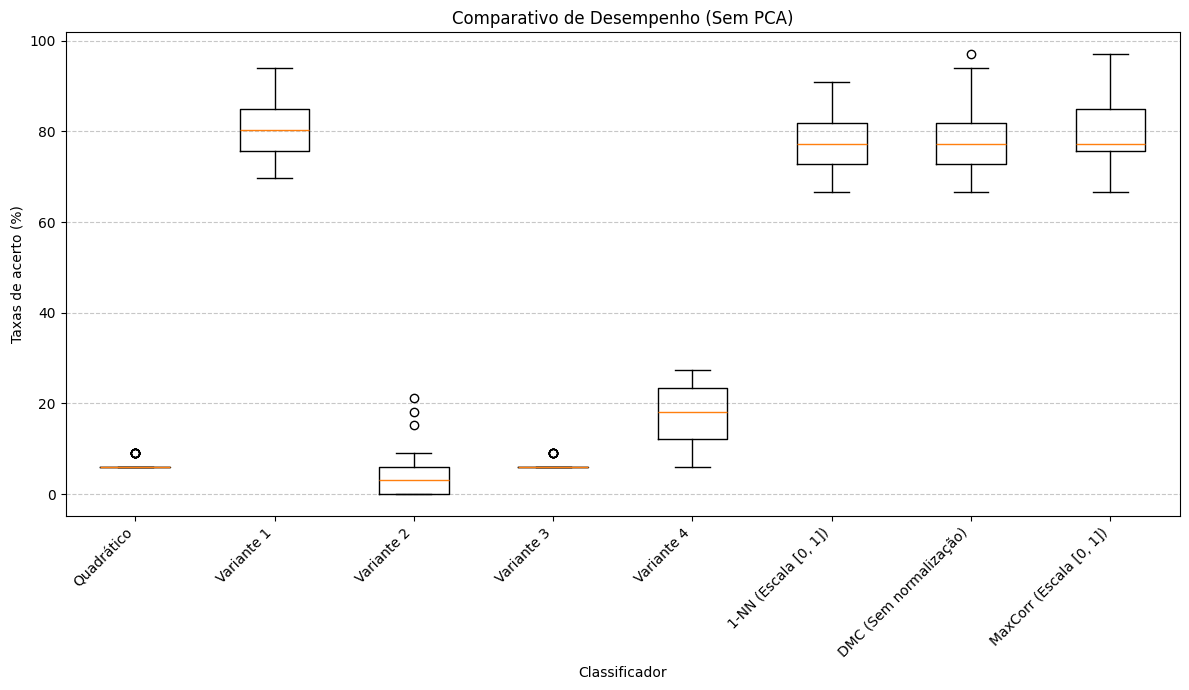

In [202]:
# Carrega os dados para o experimento
D_sem_pca = np.loadtxt('recfaces.dat') 

# Executa o experimento e gera a tabela de resultados
resultados_sem_pca, tabela_sem_pca = executar_experimento(
    D=D_sem_pca, 
    Nr=50, 
    Ptrain=80, 
    titulo_tabela="Tabela de Resultados sem PCA"
)

# Gera o boxplot a partir dos resultados obtidos
plotar_boxplot(resultados_sem_pca, "Comparativo de Desempenho (Sem PCA)")

# Aplicação do PCA para solucionar as atividades 3 e 4

Atividade 4: O 'q' teórico solicitado é 400.
No entanto, com N=165 amostras, o número máximo de componentes significativos é 164.
Portanto, o PCA será executado com q_efetivo = 164 componentes.


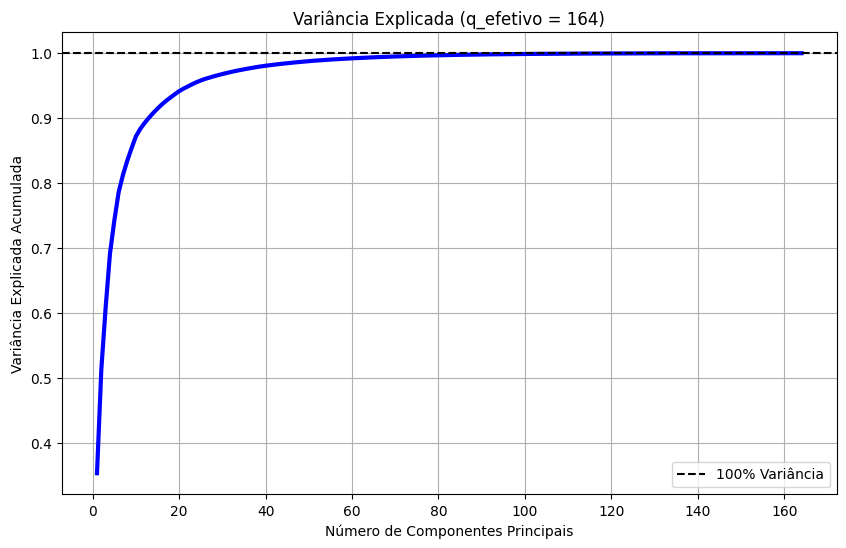

In [224]:
D_original = np.loadtxt('recfaces.dat')
X_original = D_original[:, :-1].T # Formato (400, 165)
Y_original = D_original[:, -1].reshape(1, -1) # Formato (1, 165)

q_teorico = 400

# Determinando o limite prático de componentes (N-1)
N_amostras = X_original.shape[1]
q_maximo = N_amostras - 1 

# Escolhendo o número efetivo de componentes a serem usados
q_efetivo = min(q_teorico, q_maximo)

print(f"Atividade 4: O 'q' teórico solicitado é {q_teorico}.")
print(f"No entanto, com N={N_amostras} amostras, o número máximo de componentes significativos é {q_maximo}.")
print(f"Portanto, o PCA será executado com q_efetivo = {q_efetivo} componentes.")

# Aplicando PCA com o número de componentes efetivo
pca = PCA(n_components=q_efetivo)

# O fit_transform espera (n_amostras, n_features), por isso usamos X.T
X_reduzido = pca.fit_transform(X_original.T).T # Transpõe de volta para (q, N)

# Gráfico da variância explicada
VEq = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(VEq) + 1), VEq, 'b-', linewidth=3)
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title(f'Variância Explicada (q_efetivo = {q_efetivo})')
plt.grid(True)
# Adiciona uma linha vertical para mostrar onde 100% da variância é atingida
plt.axhline(y=1.0, color='black', linestyle='--', label='100% Variância')
plt.legend()
plt.show()


# Salvando os dados transformados
Z = np.vstack((X_reduzido, Y_original))
Z = Z.T
np.savetxt('recfaces_pca_q400_efetivo.dat', Z, fmt='%.6f')

## Carregamento dos dados e execução dos classificadores com PCA 


Tabela de Resultados com PCA para q=400
Executando Classificadores Quadráticos

Executando e Otimizando Classificadores Baseados em Distância...

Tabela de Resultados com PCA para q=400
                             Média  Mínimo  Máximo  Mediana  Desvio Padrão  Tempo (s)  Matrizes Singulares
Classificador                                                                                             
Quadrático                  6.6061  6.0606  9.0909   6.0606         1.1760    17.4923                  750
Variante 1                 80.1212 69.6970 93.9394  80.3030         6.2781    69.6729                    0
Variante 2                  0.0000  0.0000  0.0000   0.0000         0.0000     2.7598                   50
Variante 3                  6.6061  6.0606  9.0909   6.0606         1.1760    16.7811                  750
Variante 4                  6.6061  6.0606  9.0909   6.0606         1.1760    15.0948                  750
1-NN (Sem normalização)    78.5455 63.6364 90.9091  78.7879     

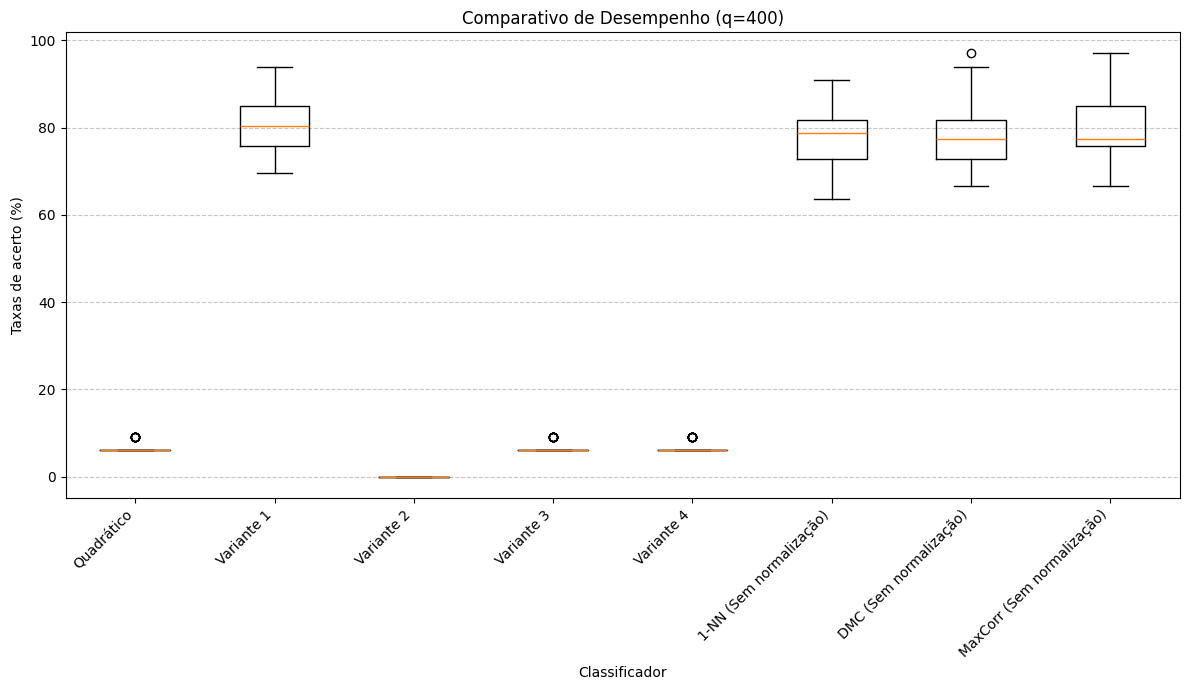

In [217]:
# Carrega os dados para o experimento
D_com_pca1 = np.loadtxt('recfaces_pca1.dat') 

# Executa o experimento e gera a tabela de resultados
resultados_com_pca1, tabela_com_pca1 = executar_experimento(
    D=D_com_pca1, 
    Nr=50, 
    Ptrain=80, 
    titulo_tabela="Tabela de Resultados com PCA para q=400"
)

# Gera o boxplot a partir dos resultados obtidos
plotar_boxplot(resultados_com_pca1, "Comparativo de Desempenho (q=400)")

# Mudança no "q" para solucionar as atividades 5 e 6

Número de componentes selecionado para reter 98% da variância: 40


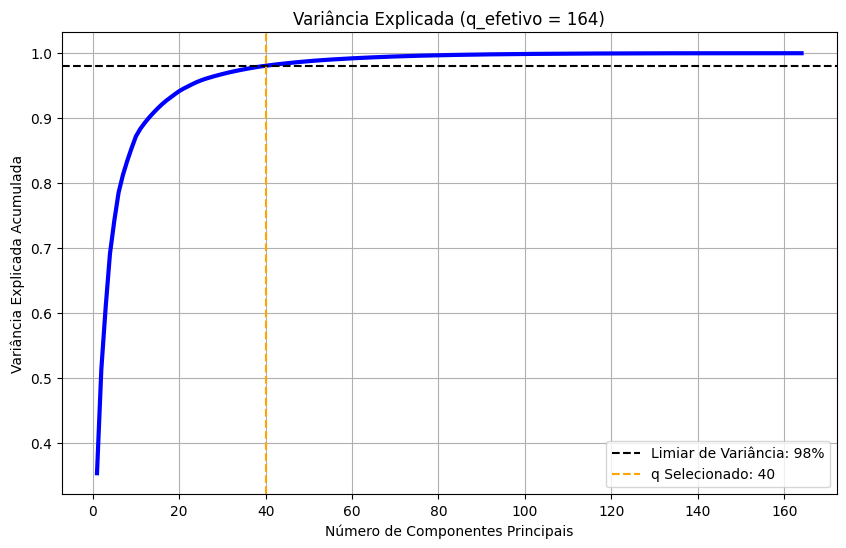

In [227]:
limiar_variancia = 0.98


pca1 = PCA(n_components=limiar_variancia)

X_reduzido1 = pca1.fit_transform(X_original.T).T # Transpõe de volta para (q, N)

q_selecionado = pca1.n_components_
print(f"Número de componentes selecionado para reter {limiar_variancia:.0%} da variância: {q_selecionado}")
# Gráfico da variância explicada
VEq1 = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(VEq) + 1), VEq, 'b-', linewidth=3)
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title(f'Variância Explicada (q_efetivo = {q_efetivo})')
plt.grid(True)
# Adiciona uma linha vertical para mostrar onde 100% da variância é atingida
plt.axhline(y=limiar_variancia, color='black', linestyle='--', label=f'Limiar de Variância: {limiar_variancia:.0%}')
plt.axvline(x=q_selecionado, color='orange', linestyle='--', label=f'q Selecionado: {q_selecionado}')

plt.legend()
plt.show()
# 6. Salvar os dados transformados em um novo arquivo
Z = np.vstack((X_reduzido1, Y_original))
Z = Z.T
np.savetxt('recfaces_pca_reduzido.dat', Z, fmt='%.6f')


In [228]:
D_com_pca2 = np.loadtxt('recfaces_pca2.dat') 
resultados_com_pca2, tabela_com_pca2 = executar_experimento(D_com_pca2, 50, 80, "Tabela de Resultados com PCA para 98% da variância")


Tabela de Resultados com PCA para 98% da variância
Executando Classificadores Quadráticos

Executando e Otimizando Classificadores Baseados em Distância...

Tabela de Resultados com PCA para 98% da variância
                       Média  Mínimo   Máximo  Mediana  Desvio Padrão  Tempo (s)  Matrizes Singulares
Classificador                                                                                        
Quadrático            6.4242  6.0606   9.0909   6.0606         0.9947     0.2532                    0
Variante 1           79.5152 69.6970  93.9394  78.7879         6.3788     0.2659                    0
Variante 2           95.8788 84.8485 100.0000  96.9697         3.6610     0.2174                    0
Variante 3           95.8182 84.8485 100.0000  96.9697         3.8179     0.2684                    0
Variante 4           77.5758 60.6061  90.9091  78.7879         7.0604     0.2635                    0
1-NN (Escala [0, 1]) 88.5455 75.7576 100.0000  87.8788         5.2768     0.0

# Aplicação do BOX-COX para a resolução da Atividade 7